In [31]:
#!/usr/bin/env python3
import qiskit
from qiskit import (
    QuantumCircuit,
    QuantumRegister,
    ClassicalRegister,
    transpile
)
from qiskit.quantum_info import (
    Kraus, 
    SuperOp,
)
from qiskit_aer.noise import(
    depolarizing_error,
    phase_damping_error,
    NoiseModel,
    QuantumError,
    amplitude_damping_error,
)
# from qiskit_ibm_provider import IBMProvider
from qiskit import Aer
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import math
import sys
sys.path.append('../')
import utilities as utl
import importlib
import json
importlib.reload(utl)
# BASIS=["h", "x", "rz", "ccx", "cx", "cz", "id"]

SHOTS=50000

def _graph_pcsZ(qc, qreg):
    print(qreg.size)
    for idx in list(range(qreg.size)):
        if idx==1:
            continue
        qc.h(qreg[idx])
    qc.cx(qreg[0], qreg[1])
    qc.cx(qreg[2],qreg[3])
    qc.cx(qreg[3],qreg[0])
    qc.cx(qreg[4],qreg[5])
    qc.cx(qreg[5],qreg[1])
    qc.barrier()
    qc.id(qreg)
    qc.barrier()
    qc.cx(qreg[5],qreg[1])
    qc.cx(qreg[4],qreg[5])
    qc.cx(qreg[3],qreg[0])
    qc.cx(qreg[2],qreg[3])
    qc.barrier() 
    qc.h([qreg[2], qreg[3], qreg[4],qreg[5]])

    return qc 

In [32]:
tot_pcs_ancillas=4
a_qreg=QuantumRegister(6, "a")
pcs_creg=ClassicalRegister(4,"pcs")
bsm_creg=ClassicalRegister(2, "bsm")
epr_creg=ClassicalRegister(2, "epr")
junk_creg=ClassicalRegister(8, "junk") #for removing and connecting nodes
qc=QuantumCircuit(a_qreg, epr_creg, bsm_creg, pcs_creg, junk_creg)
qc=_graph_pcsZ(qc, a_qreg)

# PCS measurements.
qc.barrier()
qc.measure(a_qreg[2], pcs_creg[0])
qc.measure(a_qreg[3], pcs_creg[1])
qc.measure(a_qreg[4], pcs_creg[2])
qc.measure(a_qreg[5], pcs_creg[3])

# Convert 2 qubit graph states to bell States. These cancel with h gate from the X-basis graph measeurements.
# qc.h(a_qreg[0])
# qc.h(b_qreg[0])

qc.barrier()
qc.draw(fold=-1)

6


┌───┐     ┌───┐      ░ ┌───┐ ░      ┌───┐      ░       ░              ░ 
   a_0: ┤ H ├──■──┤ X ├──────░─┤ I ├─░──────┤ X ├──────░───────░──────────────░─
        └───┘┌─┴─┐└─┬─┘┌───┐ ░ ├───┤ ░ ┌───┐└─┬─┘      ░       ░              ░ 
   a_1: ─────┤ X ├──┼──┤ X ├─░─┤ I ├─░─┤ X ├──┼────────░───────░──────────────░─
        ┌───┐└───┘  │  └─┬─┘ ░ ├───┤ ░ └─┬─┘  │        ░ ┌───┐ ░ ┌─┐          ░ 
   a_2: ┤ H ├──■────┼────┼───░─┤ I ├─░───┼────┼────■───░─┤ H ├─░─┤M├──────────░─
        ├───┤┌─┴─┐  │    │   ░ ├───┤ ░   │    │  ┌─┴─┐ ░ ├───┤ ░ └╥┘┌─┐       ░ 
   a_3: ┤ H ├┤ X ├──■────┼───░─┤ I ├─░───┼────■──┤ X ├─░─┤ H ├─░──╫─┤M├───────░─
        ├───┤└───┘       │   ░ ├───┤ ░   │       └───┘ ░ ├───┤ ░  ║ └╥┘┌─┐    ░ 
   a_4: ┤ H ├──■─────────┼───░─┤ I ├─░───┼────■────────░─┤ H ├─░──╫──╫─┤M├────░─
        ├───┤┌─┴─┐       │   ░ ├───┤ ░   │  ┌─┴─┐      ░ ├───┤ ░  ║  ║ └╥┘┌─┐ ░ 
   a_5: ┤ H ├┤ X ├───────■───░─┤ I ├─░───■──┤ X ├──────░─┤ H ├─░──╫──╫──╫─┤M├─░─
        └───┘└───┘           ░ └───┘ ░      └───┘      ░ └───┘ ░  ║  ║  ║ └╥┘ ░ 
 epr: 2/══════════════════════════════════════════════════════════╬══╬══╬══╬════
                                                                  ║  ║  ║  ║    
 bsm: 2/══════════════════════════════════════════════════════════╬══╬══╬══╬════
                                                                  ║  ║  ║  ║    
 pcs: 4/══════════════════════════════════════════════════════════╩══╩══╩══╩════
                                                                  0  1  2  3    
junk: 8/════════════════════════════════════════════════════════════════════════

In [33]:
pcs_all_fidelities=[]
pcs_post_select_rates=[]
errors=np.linspace(0.0, stop=0.5, num=11, endpoint=True)
error_gate1=0.001
# error_gate1=0
# errors=[0]
for error in errors:
        noise_model=utl.get_noise_model(error_gate1)
        print(f"depolarizing error: {error}")
        depol1=depolarizing_error(error, 1)
        noise_model.add_all_qubit_quantum_error(depol1, ["id"])
        print(noise_model)

        backend=AerSimulator(noise_model=noise_model)
        pcs_ancillas_pos=1 # the position of the classical registers that contain the pcs measurements.
        result_xx=utl.meas_xx(qc, [a_qreg[0], a_qreg[1]], epr_creg, backend, SHOTS)
        result_yy=utl.meas_yy(qc, [a_qreg[0], a_qreg[1]], epr_creg, backend, SHOTS)
        result_zz=utl.meas_zz(qc, [a_qreg[0], a_qreg[1]], epr_creg, backend, SHOTS)

        xx_counts=utl.post_select(result_xx.get_counts(), tot_pcs_ancillas, pcs_ancillas_pos)
        yy_counts=utl.post_select(result_yy.get_counts(), tot_pcs_ancillas, pcs_ancillas_pos)
        zz_counts=utl.post_select(result_zz.get_counts(), tot_pcs_ancillas, pcs_ancillas_pos)
        pcs_post_select_rates.append(min([sum(xx_counts.values()),sum(yy_counts.values()),sum(zz_counts.values())])/SHOTS)
        epr_idx=-1 #the position of the classical registers that contain measurements of the 
                #epr pair.
        expect_xx=utl.expect_of_vals(utl.to_percent(utl.collect_meas(xx_counts, epr_idx)))
        expect_yy=utl.expect_of_vals(utl.to_percent(utl.collect_meas(yy_counts, epr_idx)))
        expect_zz=utl.expect_of_vals(utl.to_percent(utl.collect_meas(zz_counts, epr_idx)))
        pcs_fidelity=utl.fidelity_phip(expect_xx, expect_yy, expect_zz)
        print(pcs_fidelity)
        pcs_all_fidelities.append(pcs_fidelity)

depolarizing error: 0.0
NoiseModel:
  Basis gates: ['ccx', 'cx', 'cz', 'h', 'id', 'rz', 'sx', 'x', 'y', 'z']
  Instructions with noise: ['rz', 'z', 'x', 'ccx', 'cx', 'h', 'cz', 'measure', 'y']
  All-qubits errors: ['cx', 'cz', 'ccx', 'h', 'x', 'y', 'z', 'rz', 'measure']
xx circ: 
        ┌───┐     ┌───┐      ░ ┌───┐ ░      ┌───┐      ░       ░             »
   a_0: ┤ H ├──■──┤ X ├──────░─┤ I ├─░──────┤ X ├──────░───────░─────────────»
        └───┘┌─┴─┐└─┬─┘┌───┐ ░ ├───┤ ░ ┌───┐└─┬─┘      ░       ░             »
   a_1: ─────┤ X ├──┼──┤ X ├─░─┤ I ├─░─┤ X ├──┼────────░───────░─────────────»
        ┌───┐└───┘  │  └─┬─┘ ░ ├───┤ ░ └─┬─┘  │        ░ ┌───┐ ░ ┌─┐         »
   a_2: ┤ H ├──■────┼────┼───░─┤ I ├─░───┼────┼────■───░─┤ H ├─░─┤M├─────────»
        ├───┤┌─┴─┐  │    │   ░ ├───┤ ░   │    │  ┌─┴─┐ ░ ├───┤ ░ └╥┘┌─┐      »
   a_3: ┤ H ├┤ X ├──■────┼───░─┤ I ├─░───┼────■──┤ X ├─░─┤ H ├─░──╫─┤M├──────»
        ├───┤└───┘       │   ░ ├───┤ ░   │       └───┘ ░ ├───┤ ░  ║ └╥┘┌─┐   »
   a_4: 

[0.9605579740818504, 0.9111038747286332, 0.8620945120366023, 0.8118096472557847, 0.7634025140891719, 0.7097698611786334, 0.6622668210776876, 0.6063584267020097, 0.5633995927848201, 0.5220794161462169, 0.47384202974548306]
[0.92734, 0.7989, 0.6869, 0.59238, 0.5065, 0.438, 0.37658, 0.32352, 0.27764, 0.23988, 0.21046]
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ]


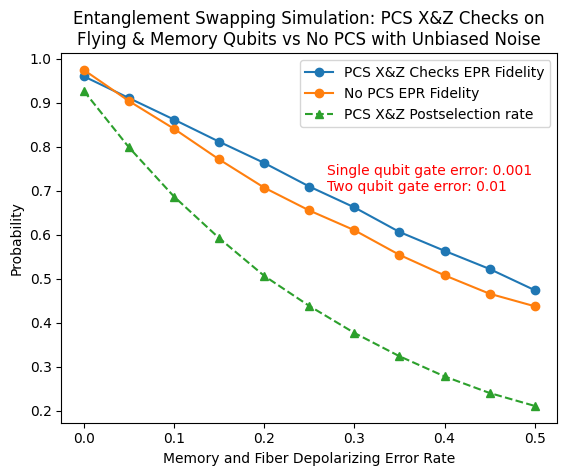

[0.9605579740818504, 0.9111038747286332, 0.8620945120366023, 0.8118096472557847, 0.7634025140891719, 0.7097698611786334, 0.6622668210776876, 0.6063584267020097, 0.5633995927848201, 0.5220794161462169, 0.47384202974548306]
[0.9751, 0.9043, 0.8412, 0.7715, 0.7071999999999999, 0.6552500000000001, 0.61035, 0.5541999999999999, 0.5077, 0.46575, 0.4372500000000001]
[0.92734, 0.7989, 0.6869, 0.59238, 0.5065, 0.438, 0.37658, 0.32352, 0.27764, 0.23988, 0.21046]
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ]


In [34]:
print(pcs_all_fidelities)
print(pcs_post_select_rates)
print(errors)
reps=2
with open(f"json\\pcsX_rep2_unbiased_noswap.json", "w") as fxz:
        json.dump({"errors": errors.tolist(), "fidelities": pcs_all_fidelities, "postselectRates": pcs_post_select_rates}, fxz)
with open("json\\raw_unbiased_noswap.json") as fRaw:
        dataRaw=json.load(fRaw)
nopcs_all_fidelities=dataRaw["fidelities"]
plt.plot(errors, pcs_all_fidelities, label="PCS X&Z Checks EPR Fidelity", marker='o')
plt.plot(errors, nopcs_all_fidelities, label="No PCS EPR Fidelity", marker='o')
plt.plot(errors, pcs_post_select_rates, label="PCS X&Z Postselection rate",  marker='^', linestyle="--")
plt.ylabel('Probability')
plt.xlabel(f"Memory and Fiber Depolarizing Error Rate")
plt.text(0.27, .7, f"Single qubit gate error: {error_gate1}\nTwo qubit gate error: {round(error_gate1*10, 4)}", color = "red")
plt.title(f"Entanglement Swapping Simulation: PCS X&Z Checks on\nFlying & Memory Qubits vs No PCS with Unbiased Noise")
plt.legend()
plt.savefig(f"images\\pcsX_rep2_unbiased_noswap.png")
plt.show()
print(pcs_all_fidelities)
print(nopcs_all_fidelities)
print(pcs_post_select_rates)
print(errors)